<a href="https://colab.research.google.com/github/NimaZah/Cry/blob/main/Infant_Cry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries and modules

In [ ]:
import glob
import shutil
from pathlib import Path
from sys import argv
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.vision import *
from fastai.metrics import error_rate
import warnings
warnings.filterwarnings("ignore")

# Standardizing the directory

In [224]:
# create a directory
path=Path('Audio/')
path.mkdir(parents=True, exist_ok=True)

In [ ]:
# Download the file from GitHub, unzip it, delete the original zip file.
os.chdir('Audio')
!wget https://github.com/gveres/donateacry-corpus/archive/master.zip
!unzip master.zip
!rm master.zip

In [226]:
# Keep only the folder with cleaned data
os.chdir('donateacry-corpus-master')
!rm -r donateacry-android-upload-bucket
!rm -r donateacry-ios-upload-bucket
!rm -r README.md
os.chdir('donateacry_corpus_cleaned_and_updated_data') 
!rm -r README.md
!mv * ../../
os.chdir('../../')
!rm -r donateacry-corpus-master

In [229]:
!mkdir /content/Spectrogram
!mkdir /content/Spectrogram/belly_pain_img
!mkdir /content/Spectrogram/burping_img
!mkdir /content/Spectrogram/discomfort_img
!mkdir /content/Spectrogram/hungry_img
!mkdir /content/Spectrogram/tired_img

!cp /content/Audio/belly_pain/* /content/Spectrogram/belly_pain_img
!cp /content/Audio/burping/* /content/Spectrogram/burping_img
!cp /content/Audio/discomfort/* /content/Spectrogram/discomfort_img
!cp /content/Audio/tired/* /content/Spectrogram/tired_img
!cp /content/Audio/hungry/* /content/Spectrogram/hungry_img

Creating the spectogram
-------------------

In [101]:
# data_path = Path('Audio/')
# spectrogram_path = Path('Spectrogram/')
# spectrogram_path.mkdir(parents=True, exist_ok=True)

In [102]:
# # Create a folder for each of the 5 classes
# !mkdir belly_pain_img
# !mkdir burping_img
# !mkdir discomfort_img
# !mkdir hungry_img
# !mkdir tired_img

In [103]:
# We will use the following function to convert wav to spectrogram.
def wav2img(wav_path, targetdir='', figsize=(4,4)):
    """
    takes in wave file path
    and the fig size. Default 4,4 will make images 288 x 288
    """
    fig = plt.figure(figsize=figsize)
    samplerate, test_sound  = wavfile.read(wav_path)
    plt.specgram(test_sound, Fs=samplerate)
    plt.axis('off')
    plt.savefig(f'{targetdir}/{Path(wav_path).stem}.png', bbox_inches='tight', pad_inches=-0.05)
    plt.close()

In [104]:
for file in os.listdir('burping'):
    wav2img('burping/' + file, 'burping_img/')
for file in os.listdir('belly_pain'):
    wav2img('belly_pain/' + file, 'belly_pain_img/')
for file in os.listdir('discomfort'):
    wav2img('discomfort/' + file, 'discomfort_img/')
for file in os.listdir('hungry'):
    wav2img('hungry/' + file, 'hungry_img/')
for file in os.listdir('tired'):
    wav2img('tired/' + file, 'tired_img/')

In [105]:
# Make a directory called spectrogram and move the img folders to spectrogram.
# !mv burping_img Spectrogram
# !mv tired_img Spectrogram
# !mv belly_pain_img Spectrogram
# !mv discomfort_img Spectrogram
# !mv hungry_img Spectrogram

In [ ]:
!zip -r Spectrogram.zip Spectrogram
from google.colab import files
files.download('Spectrogram.zip')

In [24]:
path = Path('Spectrogram')
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files, 
                   get_y=parent_label,
                   item_tfms=Resize(128),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

In [ ]:
dls.valid.show_batch(max_n=9, nrows=1)

In [ ]:
# Create a learner
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [ ]:
# Train the model
learn.fine_tune(20)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(1, nrows=5)

# Creating Dataset on Kaggle

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"nimaznzn","key":"e997999d6f8c1d6c48904a4063ec781e"}
import json

In [ ]:
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nimaznzn/cy4582

!unzip -q cy4582.zip
!rm -r cy4582.zip

In [158]:
path = Path("/content/Spectrogram")
path.ls()

(#5) [Path('/content/Spectrogram/belly_pain_img'),Path('/content/Spectrogram/hungry_img'),Path('/content/Spectrogram/burping_img'),Path('/content/Spectrogram/tired_img'),Path('/content/Spectrogram/discomfort_img')]

In [170]:
dls = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,
                                   item_tfms=Resize(224),
                                   bs=64, num_workers=0)

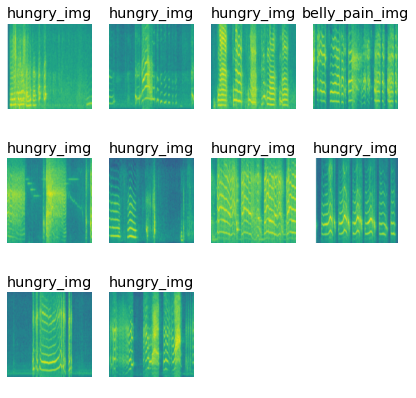

In [171]:
# dls.train.show_batch(max_n=4, nrows=1)
dls.show_batch(max_n=10, figsize=(7,7))

In [179]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
import time
t0 = time.time()
learn.fine_tune(20)
t1 = time.time()
print("time taken to fit the model: {}".format(t1-t0))

# Binary classification

In [197]:
!mkdir /content/CryData
!mkdir /content/CryData/hungray_img
!mkdir /content/CryData/not_hungray_img
!cp /content/Spectrogram/belly_pain_img/* /content/CryData/not_hungray_img
!cp /content/Spectrogram/burping_img/* /content/CryData/not_hungray_img
!cp /content/Spectrogram/tired_img/* /content/CryData/not_hungray_img
!cp /content/Spectrogram/discomfort_img/* /content/CryData/not_hungray_img
!cp /content/Spectrogram/hungry_img/* /content/CryData/hungray_img

In [213]:
path = Path("/content/CryData")
path.ls()
folders = ['hungray_img', 'not_hungray_img']

In [214]:
# dls = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,
#                                    item_tfms=Resize(224),
#                                    bs=64, num_workers=0)

Data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_y=parent_label,
                  item_tfms=Resize(224),
                  batch_tfms=aug_transforms()
                 )

In [215]:
# dls.train.show_batch(max_n=4, nrows=1)
# dls.show_batch(max_n=12, figsize=(7,7))

dls = Data.dataloaders(path, bs=64, num_workers=0)

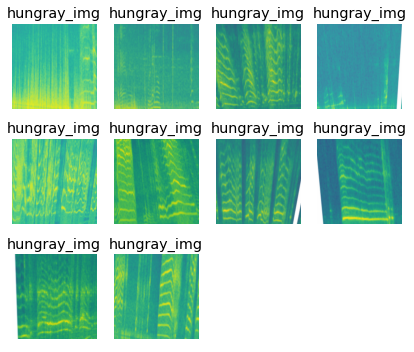

In [221]:
dls.show_batch(max_n=10, figsize=(7,6))

In [217]:
learn2 = cnn_learner(dls, resnet50, metrics=accuracy)

In [ ]:
import time
t0 = time.time()
learn2.fine_tune(20)
t1 = time.time()
print("time taken to fit the model: {}".format(t1-t0))

Keras Experiment 
----------------

In [1]:
import tensorflow as tf
from tensorflow import keras
tf.__version__
keras.__version__

'2.8.0'

In [12]:
path = Path('spectrogram')

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 238144)            0         
                                                                 
 dense (Dense)               (None, 64)                15241280  
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model = keras.models.Sequential([
    keras.layers.Reshape(target_shape=(128, 128, 1)),
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=300, activation='relu'),
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dense(units=4, activation='softmax'),
])

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files, 
                   get_y=parent_label,
                   item_tfms=Resize(128),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [23]:
dls = dblock.dataloaders(path, bs=64)
x, y = dls.one_batch()
x.shape, y.shape
model.fit(x, y, epochs=8)

TypeError: ignored

In [21]:
!pwd

/content/Audio
